# Install packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q matplotlib scikit-learn spacy

# If en_core_web_sm is not installed, comment in the following line.
# !python -m spacy download en_core_web_sm

# Load Modules

In [3]:
import concurrent.futures
import os
import sys
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

sys.path.append("..")

nlp = spacy.load("en_core_web_sm")

# Data Preparation

In [4]:
n_documents = 10000
n_vocabs = 10000

In [5]:
dataset = fetch_20newsgroups(subset="train")

In [6]:
texts = fetch_20newsgroups(subset="train")["data"][:n_documents]
class_ids = dataset["target"][:n_documents]
labels = np.array([dataset["target_names"][class_id] for class_id in class_ids])

In [7]:
def get_lemmas(text):
    doc = nlp(text)
    return [t.lemma_ for t in doc if t.pos_ not in ["PUNCT", "SPACE"]]


raw_corpus = []
n_batch_size = 1000

# see: https://stackoverflow.com/questions/76292341/concurrent-futures-misbehaves-on-python-3-8-on-mac-os
if sys.platform == "linux":
    for i in tqdm.trange(0, len(texts), n_batch_size):
        with concurrent.futures.ProcessPoolExecutor(
            max_workers=os.cpu_count()
        ) as executor:
            lemmas = list(executor.map(get_lemmas, texts[i : i + n_batch_size]))
            raw_corpus += lemmas
else:
    for text in tqdm.tqdm(texts):
        raw_corpus.append(get_lemmas(text))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.56s/it]


In [8]:
# Build vocabs

words = [word for doc in raw_corpus for word in doc]
word_freq = Counter(words)
vocabs = set([w for w, f in word_freq.most_common(10000)])

In [9]:
# Build corpus from raw_corpus and vocabs

corpus = []
for raw_doc in tqdm.tqdm(raw_corpus):
    c = []
    for word in raw_doc:
        if word in vocabs:
            c.append(word)
    corpus.append(c)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33902.76it/s]


# Neural Linear Embedding

In [10]:
# Neural Linear Embedding

from pynle import NeuralLinearEmbedding

n_latent_dimension = 64
nle = NeuralLinearEmbedding(k=n_latent_dimension)
doc_embeddings, word_embeddings = nle.fit_transform(corpus)

[pynle.py:56][INFO][2024-11-16 15:23:23,761] Building PMI matrix (10000, 10000)
100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9639.76it/s]
[pynle.py:72][INFO][2024-11-16 15:23:24,813] Executing SVD. Please wait.


# Visualization: Document Embeddings

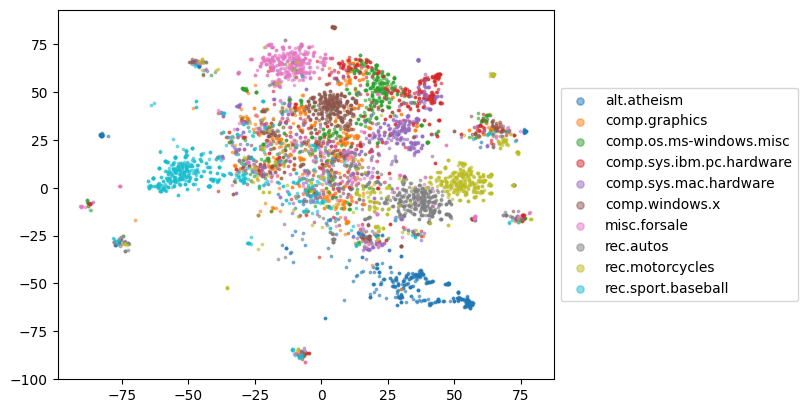

In [11]:
D = TSNE(n_components=2).fit_transform(doc_embeddings)

for i, label_name in enumerate(dataset["target_names"][:10]):
    _ix = labels == label_name
    _D = D[_ix]
    plt.scatter(_D[:, 0], _D[:, 1], s=3, label=label_name, alpha=0.5)

legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=3)

# Visualization: Word Embeddings

In [12]:
def get_similar_words(model, word, word_embeddings, n_top: int = 10) -> list[str]:
    word_id = model.word_to_id[word]
    similar_word_ids = np.argsort(word_embeddings @ word_embeddings[word_id])[::-1][
        :n_top
    ]

    return similar_word_ids, [
        model.id_to_word[similar_word_id] for similar_word_id in similar_word_ids
    ]


# get_similar_words(nle, "computer", word_embeddings, n_top=5)

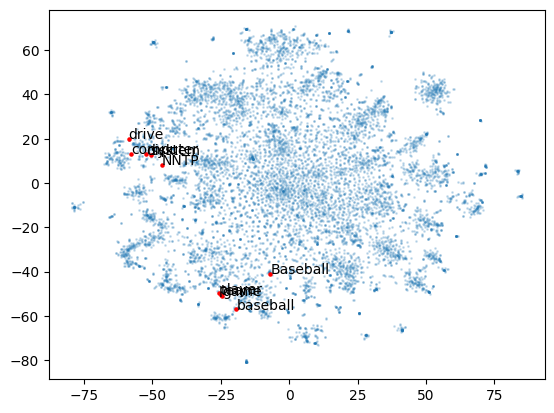

In [13]:
target_words = ["computer", "baseball"]

W = TSNE(n_components=2).fit_transform(word_embeddings)

plt.scatter(W[:, 0], W[:, 1], s=1, alpha=0.2)
for i, target_word in enumerate(target_words):
    similar_word_ids, similar_words = get_similar_words(
        nle, target_word, word_embeddings, n_top=5
    )
    for word_id, word in zip(similar_word_ids, similar_words):
        x, y = W[:, 0][word_id], W[:, 1][word_id]
        plt.scatter(x, y, s=5, c="red")
        plt.text(x, y, word)